## Welfare Ranges Calculations

### Import simulated scores


In [28]:
import os
import pickle
import copy 
import collections
import warnings
import csv
import platform
import test_simulations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from logging import warning
from operator import concat
from struct import unpack
from IPython.display import display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (18.5 * 0.65, 10.5 * 0.65)

SPECIES = ['pigs', 'chickens', 'carp', 'salmon', 'octopuses', 'shrimp', 'crabs', 'crayfish', 'bees', 'bsf', 'silkworms']

SCENARIO_RANGES = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]

params = pickle.load(open(os.path.join('input_data', "Welfare Range Parameters.p"), 'rb'))
NUM_SCENARIOS = params['N_SCENARIOS']
HC_WEIGHT = params['HC_WEIGHT']
WEIGHT_NOS = params['WEIGHT_NOS']

sent_params = pickle.load(open(os.path.join('input_data', 'Sentience Parameters.p'), 'rb'))
SENT_HC_WEIGHT = sent_params['HC_WEIGHT']

# import simulated scores
pig_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_pigs")), 'rb'))
chicken_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_chickens")), 'rb'))
carp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_carp")), 'rb'))
salmon_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_salmon")), 'rb'))
octopus_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_octopuses")), 'rb'))
shrimp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_shrimp")), 'rb'))
crab_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_crabs")), 'rb'))
crayfish_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_crayfish")), 'rb'))
bee_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_bees")), 'rb'))
bsf_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_bsf")), 'rb'))
silkworm_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_silkworms")), 'rb'))

unknown_probabilities = pickle.load(open(os.path.join('input_data', "Welfare Range Unknown Probabilities.p"), 'rb'))

overlap_csv = os.path.join('input_data', 'Proxy Overlap.csv')
overlap_dict = {}
with open(overlap_csv) as f:
    reader = csv.reader(f, delimiter=',')
    for idx, rec in enumerate(reader):
        if idx == 0:
            continue
        else:
            sent_proxy = rec[0].strip()
            in_both = rec[1].strip()
            corr_proxy = rec[2].strip()
            if in_both == "y":
                if corr_proxy not in overlap_dict:
                    overlap_dict[corr_proxy] = []
                overlap_dict[corr_proxy].append(sent_proxy)

data = {'pigs': {'Scores': pig_scores, 'FFF': 75, 'Unknown Prob': unknown_probabilities['pigs']}, 
        'chickens': {'Scores': chicken_scores, 'FFF': 50, 'Unknown Prob': unknown_probabilities['chickens']}, 
        'carp': {'Scores': carp_scores, 'FFF': 72, 'Unknown Prob': unknown_probabilities['carp']}, 
        'salmon': {'Scores': salmon_scores, 'FFF': 72, 'Unknown Prob': unknown_probabilities['salmon']},
        'octopuses': {'Scores': octopus_scores, 'FFF': 45, 'Unknown Prob': unknown_probabilities['octopuses']}, 
        'shrimp': {'Scores': shrimp_scores, 'FFF': 80, 'Unknown Prob': unknown_probabilities['shrimp']}, 
        'crabs': {'Scores': crab_scores, 'FFF': 14, 'Unknown Prob': unknown_probabilities['crabs']}, 
        'crayfish': {'Scores': crayfish_scores, 'FFF': 55, 'Unknown Prob': unknown_probabilities['crayfish']},
        'bees': {'Scores': bee_scores, 'FFF': 110, 'Unknown Prob': unknown_probabilities['bees']}, 
        'bsf': {'Scores': bsf_scores, 'FFF': None, 'Unknown Prob': unknown_probabilities['bsf']}, 
        'silkworms': {'Scores': silkworm_scores, 'FFF': None, 'Unknown Prob': unknown_probabilities['silkworms']}}

print(test_simulations.test_wr_scores(data, overlap_dict, HC_WEIGHT, SENT_HC_WEIGHT, SPECIES))

def run_cmd(cmd):
    print(cmd)
    os.system(cmd)

if platform.system() == 'Darwin' or platform.system() == 'Linux':
    run_cmd('rm -rf welfare_range_estimates')
    run_cmd('mkdir welfare_range_estimates')
elif platform.system() == 'Windows':
    run_cmd('rmdir /Q /S welfare_range_estimates')
    run_cmd('mkdir welfare_range_estimates')
else:
    raise ValueError('Platform `{}` not supported'.format(platform.system()))


All proxies with zero/one probabilities have scores equal to their expected values
Number proxies whose proportion was outside 95% CI: 10
Proportion of total proxies whose mean score was outside of the 95% CI: 0.042
Probability of getting > 10/239 proxies outside of their 95% CI: 0.653
Pass Test:
True
rmdir /Q /S welfare_range_estimates
mkdir welfare_range_estimates


## Import Proxies Lists for Each Model


In [29]:
# import proxies lists for each model
model_proxies_df = pd.read_csv(os.path.join('input_data', 'WR Model Proxies.csv'))
# qualitative proxies
qual_proxies_list = model_proxies_df['qualitative'].dropna().values.tolist()
qual_proxies = set()
for proxy in qual_proxies_list:
    if proxy.lower() != "none":
        qual_proxies.add(proxy)

# cubic proxies
cubic_proxies_list = model_proxies_df['cubic'].dropna().values.tolist()
cubic_proxies = set()
for proxy in cubic_proxies_list:
    if proxy.lower() != "none":
        cubic_proxies.add(proxy)

# high-confidence proxies
hc_csv = os.path.join('input_data', 'WR High-Confidence Proxies.csv')
hc_proxies = set()
with open(hc_csv, newline='') as f:
    reader = csv.reader(f)
    hc_proxies_lists = list(reader)
for i, item in enumerate(hc_proxies_lists):
    if i == 0:
        continue
    else:
        hc_proxies.add(item[0])

# qualitative minus social (QMS) proxies
qms_proxies_list = model_proxies_df['qualitative minus social'].dropna().values.tolist()
qms_proxies = set()
for proxy in qms_proxies_list:
    if proxy.lower() != "none":
        qms_proxies.add(proxy)

# pleasure-and-pain-centric (PPC) proxies
ppc_proxies_list = model_proxies_df['pleasure-and-pain-centric'].dropna().values.tolist()
ppc_proxies = set()
for proxy in ppc_proxies_list:
    if proxy.lower() != "none":
        ppc_proxies.add(proxy)

# higher/lower cognitive pleasures (HLP_COG) proxies
hlp_cog_proxies_list = model_proxies_df['higher/lower pleasures - cognitive'].dropna().values.tolist()
hlp_cog_proxies = set()
for proxy in hlp_cog_proxies_list:
    if proxy.lower() != "none":
        hlp_cog_proxies.add(proxy)

# higher/lower hedonic pleasures (HLP_HED) proxies
hlp_hed_proxies_list = model_proxies_df['higher/lower pleasures - hedonic'].dropna().values.tolist()
hlp_hed_proxies = set()
for proxy in hlp_hed_proxies_list:
    if proxy.lower() != "none":
        hlp_hed_proxies.add(proxy)

# undiluted experience cognitive pleasures (UE_COG) proxies
ue_cog_proxies_list = model_proxies_df['undiluted experience - cognitive'].dropna().values.tolist()
ue_cog_proxies = set()
for proxy in ue_cog_proxies_list:
    if proxy.lower() != "none":
        ue_cog_proxies.add(proxy)

# higher/lower hedonic pleasures (HLP_HED) proxies
ue_hed_proxies_list = model_proxies_df['undiluted experience - hedonic'].dropna().values.tolist()
ue_hed_proxies = set()
for proxy in ue_hed_proxies_list:
    if proxy.lower() != "none":
        ue_hed_proxies.add(proxy)

## General Code for Generating Welfare Range Distributions (Simple Scoring)

In [30]:

def filter_proxies(species_scores, model_proxies):
    filtered_scores = {}
    for proxy, scores_list in species_scores.items():
        if proxy in model_proxies:
            filtered_scores[proxy] = scores_list
    return filtered_scores

def get_human_sum(model_name, model_proxies, hc_proxies):
    human_sum = 0

    for proxy in model_proxies:
        if model_name in {"High-Confidence (Simple Scoring)", "High-Confidence (Cubic)"}:
            human_sum += 1
        else:
            if proxy in hc_proxies:
                human_sum += HC_WEIGHT
            else:
                human_sum += 1
    return human_sum

def one_sim_welfare_range(model_name, f, filtered_scores, sim_idx, fff_spec, pig_filtered_scores, fff_pig):
    species_welfare_sum = 0
    pig_welfare_sum = 0
    for scores_list in filtered_scores.values():
        score_i = scores_list[sim_idx]
        if model_name in {"High-Confidence (Simple Scoring)", "High-Confidence (Cubic)"}:
            score_i = score_i/HC_WEIGHT
        species_welfare_sum += score_i

    for pig_scores_list in pig_filtered_scores.values():
        pig_score_i = pig_scores_list[sim_idx]
        if model_name in {"High-Confidence (Simple Scoring)", "High-Confidence (Cubic)"}:
            pig_score_i = pig_score_i/HC_WEIGHT
        pig_welfare_sum += pig_score_i

    adjusted_species_sum = f(species_welfare_sum)
    adjusted_pig_sum = f(pig_welfare_sum)
    if fff_spec is not None:
        ffr = fff_spec/fff_pig 
        welfare_range = max(0.28*(adjusted_species_sum/adjusted_pig_sum)*ffr + 0.72*(adjusted_species_sum/adjusted_pig_sum), 0)
    else: 
        welfare_range = max(adjusted_species_sum/adjusted_pig_sum, 0)
    return welfare_range

def one_species_welfare_ranges(model_name, f, species_scores, model_proxies, fff_spec, pig_scores, fff_pig):
    spec_filtered_scores = filter_proxies(species_scores, model_proxies)
    pigs_filtered_scores = filter_proxies(pig_scores, model_proxies)
    
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range(model_name, f, spec_filtered_scores, i, fff_spec, pigs_filtered_scores, fff_pig)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list

def plot_range_distribution(species, welfare_range_list):
    welfare_range_array = np.array(welfare_range_list)
    plt.hist(welfare_range_array, bins=20, density=True)
    plt.axvline(x=np.percentile(welfare_range_array, SCENARIO_RANGES)[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(x=np.percentile(welfare_range_array, SCENARIO_RANGES)[11], color='k', linestyle='dashed', linewidth=1)
    plt.title("Distribution of {} Welfare Ranges".format(species))
    plt.show()
    print('-')

def one_species_summary_stats(species, welfare_range_list, to_print=False):
    welfare_range_array = np.array(welfare_range_list)
    percentiles = np.percentile(welfare_range_array, SCENARIO_RANGES)
    mean = np.mean(welfare_range_array)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (mean, fifth_percentile, median, ninty_fifth_percentile)
    if to_print:
        print("Mean welfare range: {}".format(mean))
        print("5th-percentile welfare range: {}".format(fifth_percentile))
        print("50th-percentile welfare range: {}".format(median))
        print("95th-percentile welfare range: {}".format(ninty_fifth_percentile))
    return stats_tuple

def all_species_welfare_ranges_simple_scoring(f, model_name, data, model_proxies, SPECIES, to_plot=False):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []

    pig_scores = data["pigs"]["Scores"]
    fff_pig = data["pigs"]["FFF"]      

    for species in SPECIES: 
        species_scores = data[species]["Scores"]
        fff_species = data[species]["FFF"]

        species_welfare_range_lst = one_species_welfare_ranges(model_name, f, species_scores, model_proxies, fff_species, pig_scores, fff_pig)
        pickle.dump(np.array(species_welfare_range_lst), open(os.path.join('welfare_range_estimates','{}_wr_{}_model.p'.format(species, model_name)), 'wb'))
        if to_plot:
            plot_range_distribution(species, species_welfare_range_lst)
        species_stats = one_species_summary_stats(species, species_welfare_range_lst)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean", "5th-pct", "50th-pct", "95th-pct"]
    welfare_range_stats_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    welfare_range_stats_df = welfare_range_stats_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR {} Summary Statistics.csv".format(model_name))
    wfr_stats_csv = welfare_range_stats_df.to_csv(path, index_label="Species")
    print(model_name.upper())
    print(welfare_range_stats_df)
    return welfare_range_stats_df

    

## Parameters for these Simulations

In [31]:
print("For all the models below, the assumptions are that...")

if WEIGHT_NOS == "Yes":
    print("'Likely no's and 'Lean no's are given probabilities between [0,0.25) and [0.25,0.5) of being true.")
else:
    print("'Likely no's and 'Lean no's are given no probability of being true.")

print("Proxies we're higly confident matter for welfare capacities are given", HC_WEIGHT, "x the weight of other proxies.")

def unknown_probs_df():
    unknown_probs = []
    for species in SPECIES:
        unknown_prob = data[species]["Unknown Prob"]
        unknown_probs.append(unknown_prob)
    cols = ['Unknown Prob.']
    unknowns_df = pd.DataFrame(unknown_probs, columns=cols, index=SPECIES)
    print(unknowns_df) 

unknown_probs_df()


For all the models below, the assumptions are that...
'Likely no's and 'Lean no's are given probabilities between [0,0.25) and [0.25,0.5) of being true.
Proxies we're higly confident matter for welfare capacities are given 5.0 x the weight of other proxies.
           Unknown Prob.
pigs                   0
chickens               0
carp                   0
salmon                 0
octopuses              0
shrimp                 0
crabs                  0
crayfish               0
bees                   0
bsf                    0
silkworms              0


## Qualitative Model

In [32]:
def qual_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

qual_wr_stats = all_species_welfare_ranges_simple_scoring(qual_f, "Qualitative", data, qual_proxies, SPECIES, to_plot=False)


QUALITATIVE
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.746    0.605     0.739     0.900
bees       0.663    0.516     0.660     0.824
carp       0.609    0.468     0.605     0.761
octopuses  0.592    0.464     0.590     0.733
salmon     0.451    0.348     0.449     0.557
crayfish   0.354    0.258     0.353     0.456
shrimp     0.294    0.202     0.293     0.388
crabs      0.243    0.170     0.242     0.320
bsf        0.191    0.119     0.191     0.263
silkworms  0.180    0.105     0.180     0.256


## High-Confidence (Simple Scoring)

In [33]:
def ss_hc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

ss_hc_wr_stats = all_species_welfare_ranges_simple_scoring(ss_hc_f, "High-Confidence (Simple Scoring)", data, hc_proxies, SPECIES, to_plot=False)

HIGH-CONFIDENCE (SIMPLE SCORING)
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.718    0.558     0.710     0.907
bees       0.660    0.492     0.660     0.848
carp       0.609    0.449     0.602     0.791
octopuses  0.590    0.444     0.581     0.755
salmon     0.452    0.330     0.449     0.572
crayfish   0.347    0.231     0.347     0.463
shrimp     0.287    0.177     0.285     0.399
crabs      0.238    0.154     0.235     0.325
bsf        0.187    0.100     0.185     0.273
silkworms  0.166    0.080     0.167     0.250


## Cubic Model

In [34]:
def cubic_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum**3
    return adjusted_welfare_sum

cubic_wr_stats = all_species_welfare_ranges_simple_scoring(cubic_f, "Cubic", data, cubic_proxies, SPECIES, to_plot=False)

CUBIC
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.529    0.272     0.494     0.887
octopuses  0.281    0.129     0.263     0.501
carp       0.246    0.105     0.228     0.451
bees       0.245    0.110     0.228     0.441
salmon     0.100    0.044     0.094     0.178
crayfish   0.057    0.021     0.052     0.112
shrimp     0.027    0.008     0.024     0.055
crabs      0.026    0.008     0.023     0.054
bsf        0.008    0.002     0.007     0.018
silkworms  0.007    0.001     0.006     0.017


## High-Confidence Proxies (Cubic Model)

In [35]:
def cubic_hc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum**3
    return adjusted_welfare_sum

hc_cubic_wr_stats = all_species_welfare_ranges_simple_scoring(cubic_hc_f, "High-Confidence (Cubic)", data, \
    hc_proxies, SPECIES, to_plot=False)

HIGH-CONFIDENCE (CUBIC)
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.480    0.211     0.435     0.907
octopuses  0.281    0.111     0.249     0.545
bees       0.244    0.093     0.224     0.477
carp       0.252    0.093     0.223     0.506
salmon     0.102    0.037     0.093     0.192
crayfish   0.055    0.014     0.049     0.116
shrimp     0.026    0.005     0.022     0.061
crabs      0.026    0.006     0.022     0.058
bsf        0.008    0.001     0.006     0.020
silkworms  0.006    0.001     0.005     0.016


## Qualitative Minus Social Model

In [36]:
def qms_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

qms_wr_stats = all_species_welfare_ranges_simple_scoring(qms_f, "Qualitative Minus Social", data, \
    qms_proxies, SPECIES, to_plot=False)

QUALITATIVE MINUS SOCIAL
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.739    0.590     0.733     0.911
bees       0.672    0.509     0.668     0.853
octopuses  0.634    0.490     0.628     0.793
carp       0.591    0.441     0.588     0.755
salmon     0.452    0.338     0.449     0.568
crayfish   0.352    0.249     0.350     0.459
shrimp     0.317    0.213     0.317     0.424
crabs      0.262    0.178     0.260     0.349
bsf        0.201    0.121     0.200     0.283
silkworms  0.189    0.105     0.189     0.275


## Pleasure-and-pain-centric Model

In [37]:
def ppc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

ppc_wr_stats = all_species_welfare_ranges_simple_scoring(ppc_f, "Pleasure-and-pain-centric", data, ppc_proxies, \
    SPECIES, to_plot=False)

PLEASURE-AND-PAIN-CENTRIC
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
carp       0.810    0.563     0.800     1.099
octopuses  0.808    0.596     0.796     1.059
chickens   0.709    0.512     0.701     0.941
salmon     0.648    0.448     0.641     0.870
bees       0.640    0.398     0.632     0.900
crayfish   0.485    0.304     0.480     0.674
shrimp     0.462    0.279     0.458     0.658
crabs      0.385    0.233     0.380     0.550
silkworms  0.226    0.092     0.229     0.362
bsf        0.189    0.081     0.186     0.296


## General Code for Non-Simple Scoring Welfare Ranges


In [38]:
def one_sim_relative_score(species_filtered_scores, sim_idx, pig_filtered_scores):
    species_welfare_sum = 0
    pig_welfare_sum = 0

    for species_scores_list in species_filtered_scores.values():
        species_score_i = species_scores_list[sim_idx]
        species_welfare_sum += species_score_i

    for pig_scores_list in pig_filtered_scores.values():
        pig_score_i = pig_scores_list[sim_idx]
        pig_welfare_sum += pig_score_i

    relative_score = species_welfare_sum/pig_welfare_sum
    return relative_score

def one_sim_welfare_range_2(f, species_cog_scores, species_hed_scores, pig_cog_scores, pig_hed_scores, sim_idx, fff_spec, fff_pig):
    cog_ratio = one_sim_relative_score(species_cog_scores, sim_idx, pig_cog_scores)
    hed_ratio = one_sim_relative_score(species_hed_scores, sim_idx, pig_hed_scores)
    prelim_welfare_range = f(cog_ratio, hed_ratio)
    if fff_spec is not None:
        ffr = fff_spec/fff_pig
        adjusted_welfare_range = max(0.28*prelim_welfare_range*ffr + 0.72*prelim_welfare_range, 0)
    else:
        adjusted_welfare_range = max(prelim_welfare_range, 0)
    return adjusted_welfare_range

def one_species_welfare_ranges_2(f, species_scores, cog_proxies, hed_proxies, fff_spec, pig_scores, fff_pig):
    species_cognitive_scores = filter_proxies(species_scores, cog_proxies)
    species_hedonic_scores = filter_proxies(species_scores, hed_proxies)

    pig_cognitive_scores = filter_proxies(pig_scores, cog_proxies)
    pig_hedonic_scores = filter_proxies(pig_scores, hed_proxies)
  
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range_2(f, species_cognitive_scores, species_hedonic_scores, \
                                                pig_cognitive_scores, pig_hedonic_scores, i, fff_spec, fff_pig)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list

def all_species_welfare_ranges_2(f, model_name, data, cognitive_proxies, hedonic_proxies, SPECIES, to_plot=False):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []

    pig_scores = data["pigs"]["Scores"]
    fff_pig = data["pigs"]["FFF"]

    for species in SPECIES: 
        species_scores = data[species]["Scores"]
        fff_species = data[species]["FFF"]
        species_welfare_range_lst = one_species_welfare_ranges_2(f, species_scores, cognitive_proxies, hedonic_proxies, \
            fff_species, pig_scores, fff_pig)
        pickle.dump(np.array(species_welfare_range_lst), open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model_name)), 'wb'))
        if to_plot:
            plot_range_distribution(species, species_welfare_range_lst)
        species_stats = one_species_summary_stats(species, species_welfare_range_lst)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean", "5th-pct", "50th-pct", "95th-pct"]
    welfare_range_stats_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    welfare_range_stats_df = welfare_range_stats_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR {} - Summary Statistics.csv".format(model_name))
    wfr_stats_csv = welfare_range_stats_df.to_csv(path, index_label="Species")
    print(model_name.upper())
    print(welfare_range_stats_df)
    return welfare_range_stats_df


## Higher/Lower Pleasures Model

In [39]:
def hlp_f(cog_ratio, hed_ratio):
    welfare_range = cog_ratio*hed_ratio
    return welfare_range

hlp_wr_stats = all_species_welfare_ranges_2(hlp_f, "Higher-Lower Pleasures", data, hlp_cog_proxies, \
    hlp_hed_proxies, SPECIES, to_plot=False)

HIGHER-LOWER PLEASURES
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.607    0.353     0.579     0.948
bees       0.340    0.166     0.326     0.566
carp       0.332    0.159     0.316     0.563
octopuses  0.331    0.157     0.313     0.560
salmon     0.182    0.088     0.175     0.298
crayfish   0.083    0.030     0.078     0.149
crabs      0.065    0.024     0.061     0.118
shrimp     0.062    0.021     0.059     0.114
bsf        0.047    0.014     0.044     0.092
silkworms  0.038    0.007     0.035     0.081


## Undiluted Experience Model

In [40]:
def ue_f(cog_ratio, hed_ratio):
    if cog_ratio > 0:
        welfare_range = hed_ratio/cog_ratio
    else:
        welfare_range = hed_ratio/0.01
    return welfare_range

ue_wr_stats = all_species_welfare_ranges_2(ue_f, "Undiluted Experience", data, ue_cog_proxies, \
    ue_hed_proxies, SPECIES, to_plot=False)

UNDILUTED EXPERIENCE
            Mean  5th-pct  50th-pct  95th-pct
shrimp     2.536    1.059     2.085     5.653
octopuses  1.755    0.995     1.636     2.898
carp       1.401    0.780     1.313     2.293
salmon     1.219    0.702     1.158     1.937
crayfish   1.232    0.607     1.122     2.205
silkworms  1.381    0.422     1.095     3.449
crabs      1.149    0.535     1.032     2.110
pigs       1.000    1.000     1.000     1.000
chickens   0.913    0.570     0.886     1.349
bsf        0.913    0.296     0.800     1.813
bees       0.762    0.415     0.731     1.209


## Mixture Model

In [41]:
import squigglepy as sq

model_results = {'Qualitative': qual_wr_stats, 'High-Confidence Simple Scoring': ss_hc_wr_stats, \
    'Cubic': cubic_wr_stats, 'High-Confidence Cubic': hc_cubic_wr_stats, \
    'Qualitative Minus Social': qms_wr_stats, 'Pleasure-and-pain-centric': ppc_wr_stats, \
    'Higher-Lower Pleasures': hlp_wr_stats, 'Undiluted Experience': ue_wr_stats}

def mixture_one_species(model_results, species, wts):
    # Qualitative
    qual_lower = model_results['Qualitative'].loc[species]['5th-pct']
    qual_upper = model_results['Qualitative'].loc[species]['95th-pct']

    # High-Confidence (simple scoring)
    ss_hc_lower = model_results['High-Confidence Simple Scoring'].loc[species]['5th-pct']
    ss_hc_upper = model_results['High-Confidence Simple Scoring'].loc[species]['95th-pct']
    
    # Cubic
    cubic_lower = model_results['Cubic'].loc[species]['5th-pct']
    cubic_upper = model_results['Cubic'].loc[species]['95th-pct']
    
    # High-confidence (Cubic)
    hc_cubic_lower = model_results['High-Confidence Cubic'].loc[species]['5th-pct']
    hc_cubic_upper = model_results['High-Confidence Cubic'].loc[species]['95th-pct']
    
    # Qualitative Minus Social
    qms_lower = model_results['Qualitative Minus Social'].loc[species]['5th-pct']
    qms_upper = model_results['Qualitative Minus Social'].loc[species]['95th-pct']
    
    # Pleasure-and-pain-centric
    ppc_lower = model_results['Pleasure-and-pain-centric'].loc[species]['5th-pct']
    ppc_upper = model_results['Pleasure-and-pain-centric'].loc[species]['95th-pct']
    
    # Higher-Lower Pleasures
    hlp_lower = model_results['Higher-Lower Pleasures'].loc[species]['5th-pct']
    hlp_upper = model_results['Higher-Lower Pleasures'].loc[species]['95th-pct']
    
    # Undiluted Experience
    ue_lower = model_results['Undiluted Experience'].loc[species]['5th-pct']
    ue_upper = model_results['Undiluted Experience'].loc[species]['95th-pct']

    mix = sq.mixture([sq.norm(qual_lower, qual_upper, lclip=0), sq.norm(ss_hc_lower, ss_hc_upper, lclip=0), \
        sq.norm(cubic_lower, cubic_upper, lclip=0), sq.norm(hc_cubic_lower, hc_cubic_upper, lclip=0), \
        sq.norm(qms_lower, qms_upper, lclip=0), sq.norm(ppc_lower, ppc_upper, lclip=0), \
        sq.norm(hlp_lower, hlp_upper, lclip=0), sq.lognorm(ue_lower, ue_upper, lclip=0)], weights = wts) 

    dist = sq.sample(mix, n=NUM_SCENARIOS)
    pickle.dump(dist, open(os.path.join('welfare_range_estimates', '{}_wr_Mixture_model.p'.format(species)), 'wb'))

    return dist

def one_species_stats(dist):
    percentiles = np.percentile(dist, SCENARIO_RANGES)
    mean = np.mean(dist)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (mean, fifth_percentile, median, ninty_fifth_percentile)
    return stats_tuple

def all_species_mixture(model_results, weights):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    weights_dict = {'Qualitative': weights[0], 'High-Confidence (Simple Scoring)': weights[1], \
    'Cubic': weights[2], 'High-Confidence (Cubic)': weights[3], \
    'Qualitative Minus Social': weights[4], 'Pleasure-and-pain-centric': weights[5], \
    'Higher-Lower Pleasures': weights[6], 'Undiluted Experience': weights[7]}

    for species in SPECIES: 
        mix_species = mixture_one_species(model_results, species, weights)
        species_stats = one_species_stats(mix_species)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean","5th-pct", "50th-pct", "95th-pct"]
    mixture_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    mixture_df = mixture_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR Mixture Model - Summary Statistics.csv")
    mixture_df.to_csv(path, index_label="Species")
    print("Weights:")
    print(weights_dict)
    print("Mixture of all Models:")
    print(mixture_df)
    return mixture_df

mixture = all_species_mixture(model_results, [1/8]*8)


Weights:
{'Qualitative': 0.125, 'High-Confidence (Simple Scoring)': 0.125, 'Cubic': 0.125, 'High-Confidence (Cubic)': 0.125, 'Qualitative Minus Social': 0.125, 'Pleasure-and-pain-centric': 0.125, 'Higher-Lower Pleasures': 0.125, 'Undiluted Experience': 0.125}
Mixture of all Models:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.710    0.372     0.720     1.003
octopuses  0.684    0.199     0.576     1.865
bees       0.541    0.173     0.573     0.870
carp       0.622    0.169     0.566     1.434
salmon     0.456    0.073     0.422     1.252
crayfish   0.384    0.038     0.320     1.322
shrimp     0.543    0.017     0.272     2.819
crabs      0.297    0.019     0.222     1.158
bsf        0.212    0.005     0.158     0.837
silkworms  0.281    0.004     0.147     1.416


## Mixture with Neuron Count

In [42]:
neuron_counts = {'pigs': 0.005350, 'chickens': 0.002439, 
                'carp': 0.000160, 'salmon': 0.000160, 
                'octopuses': 0.005407, 'shrimp': 0.000001, 
                'crabs': 0.000001, 'crayfish': 0.000001, 
                'bees': 0.000013, 'bsf': 0.000004, 
                'silkworms': 0.00001}

def mixture_one_species_with_neuron_count(model_results, species, wts):
    # Neuron Count
    neuron_count = neuron_counts[species]
    pig_neuron_count = neuron_counts['pigs']
    relative_neuron_count = neuron_count/pig_neuron_count
    # Qualitative
    qual_lower = model_results['Qualitative'].loc[species]['5th-pct']
    qual_upper = model_results['Qualitative'].loc[species]['95th-pct']

    # High-Confidence (simple scoring)
    ss_hc_lower = model_results['High-Confidence Simple Scoring'].loc[species]['5th-pct']
    ss_hc_upper = model_results['High-Confidence Simple Scoring'].loc[species]['95th-pct']
    
    # Cubic
    cubic_lower = model_results['Cubic'].loc[species]['5th-pct']
    cubic_upper = model_results['Cubic'].loc[species]['95th-pct']
    
    # High-confidence (Cubic)
    hc_cubic_lower = model_results['High-Confidence Cubic'].loc[species]['5th-pct']
    hc_cubic_upper = model_results['High-Confidence Cubic'].loc[species]['95th-pct']
    
    # Qualitative Minus Social
    qms_lower = model_results['Qualitative Minus Social'].loc[species]['5th-pct']
    qms_upper = model_results['Qualitative Minus Social'].loc[species]['95th-pct']
    
    # Pleasure-and-pain-centric
    ppc_lower = model_results['Pleasure-and-pain-centric'].loc[species]['5th-pct']
    ppc_upper = model_results['Pleasure-and-pain-centric'].loc[species]['95th-pct']
    
    # Higher-Lower Pleasures
    hlp_lower = model_results['Higher-Lower Pleasures'].loc[species]['5th-pct']
    hlp_upper = model_results['Higher-Lower Pleasures'].loc[species]['95th-pct']
    
    # Undiluted Experience
    ue_lower = model_results['Undiluted Experience'].loc[species]['5th-pct']
    ue_upper = model_results['Undiluted Experience'].loc[species]['95th-pct']

    mix = sq.mixture([sq.uniform(relative_neuron_count, relative_neuron_count), sq.norm(qual_lower, qual_upper, lclip=0), sq.norm(ss_hc_lower, ss_hc_upper, lclip=0), \
        sq.norm(cubic_lower, cubic_upper, lclip=0), sq.norm(hc_cubic_lower, hc_cubic_upper, lclip=0), \
        sq.norm(qms_lower, qms_upper, lclip=0), sq.norm(ppc_lower, ppc_upper, lclip=0), \
        sq.norm(hlp_lower, hlp_upper, lclip=0), sq.lognorm(ue_lower, ue_upper, lclip=0)], weights = wts) 

    dist = sq.sample(mix, n=NUM_SCENARIOS)
    pickle.dump(dist, open(os.path.join('welfare_range_estimates', '{}_wr_Mixture Neuron Count_model.p'.format(species)), 'wb'))

    return dist

def one_species_stats(dist):
    percentiles = np.percentile(dist, SCENARIO_RANGES)
    mean = np.mean(dist)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (mean, fifth_percentile, median, ninty_fifth_percentile)
    return stats_tuple

def all_species_mixture_with_neuron_counts(model_results, weights):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    weights_dict = {'Neuron Count': weights[0], 'Qualitative': weights[1], 'High-Confidence (Simple Scoring)': weights[2], \
    'Cubic': weights[3], 'High-Confidence (Cubic)': weights[4], \
    'Qualitative Minus Social': weights[5], 'Pleasure-and-pain-centric': weights[6], \
    'Higher-Lower Pleasures': weights[7], 'Undiluted Experience': weights[8]}

    for species in SPECIES: 
        mix_species = mixture_one_species_with_neuron_count(model_results, species, weights)
        species_stats = one_species_stats(mix_species)
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean","5th-pct", "50th-pct", "95th-pct"]
    mixture_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    mixture_df = mixture_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR Mixture Model Neuron Count - Summary Statistics.csv")
    mixture_df.to_csv(path, index_label="Species")
    print("Weights:")
    print(weights_dict)
    print("Mixture of all Models:")
    print(mixture_df)
    return mixture_df


_count = all_species_mixture_with_neuron_counts(model_results, [1/9]*9)

Weights:
{'Neuron Count': 0.1111111111111111, 'Qualitative': 0.1111111111111111, 'High-Confidence (Simple Scoring)': 0.1111111111111111, 'Cubic': 0.1111111111111111, 'High-Confidence (Cubic)': 0.1111111111111111, 'Qualitative Minus Social': 0.1111111111111111, 'Pleasure-and-pain-centric': 0.1111111111111111, 'Higher-Lower Pleasures': 0.1111111111111111, 'Undiluted Experience': 0.1111111111111111}
Mixture of all Models:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.681    0.392     0.692     0.987
octopuses  0.720    0.203     0.611     1.771
bees       0.483    0.002     0.528     0.858
carp       0.562    0.030     0.525     1.422
salmon     0.406    0.030     0.381     1.219
crayfish   0.339    0.000     0.288     1.245
shrimp     0.471    0.000     0.238     2.567
crabs      0.265    0.000     0.199     1.072
bsf        0.183    0.001     0.128     0.748
silkworms  0.256    0.002     0.125     1.308


## P(Sentience Adjusted Welfare Ranges)

In [43]:

SPECIES2 = ['pigs', 'chickens', 'carp', 'octopuses', 'bees', 'salmon', 'crayfish', 'shrimp',  'crabs', 'bsf', 'silkworms']

SPECIES_CAPS = ['Pigs', 'Chickens', 'Carp', 'Octopuses', 'Bees', 'Salmon', 'Crayfish', 'Shrimp',  'Crabs', 'Black Soldier Flies', 'Silkworms']

models = ['Qualitative', 'High-Confidence (Simple Scoring)', \
    'Cubic', 'High-Confidence (Cubic)', \
    'Qualitative Minus Social', 'Pleasure-and-pain-centric', \
    'Higher-Lower Pleasures', 'Undiluted Experience', "Mixture", "Mixture Neuron Count"]

def one_species_adj_wr(species, model_name, psent_pig):
    if species != 'shrimp':
        with open(os.path.join('sentience_estimates', '{}_psent_hv1_model.p'.format(species)), 'rb') as f_s:
            species_psent = list(pickle.load(f_s))
    else:
        with open(os.path.join('sentience_estimates', 'shrimp_assumed_psent.p'), 'rb') as f_s:
            species_psent = list(pickle.load(f_s))

    with open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model_name)), 'rb') as f_wr:
        species_wr = list(pickle.load(f_wr)) 
    species_adj_wr = []

    for i in range(NUM_SCENARIOS):
        psent_i = species_psent[i]
        psent_pig_i = psent_pig[i]
        wr_i = species_wr[i]
        adj_wr_i = max(psent_i*wr_i/psent_pig_i, 0)
        species_adj_wr.append(adj_wr_i)

    pickle.dump(species_adj_wr, open(os.path.join('sent_adj_welfare_ranges', '{}_wr_{}.p'.format(species, model_name)), 'wb'))
    
    return species_adj_wr

import seaborn as sns

def all_species_adj_wr(model_name):
    means = []
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    species_adj_wrs = []

    with open(os.path.join('sentience_estimates', 'pigs_psent_hv1_model.p'), 'rb') as f_s:
            pig_psent = list(pickle.load(f_s))

    for species in SPECIES2: 
        wrs_species = one_species_adj_wr(species, model_name, pig_psent)
        species_adj_wrs.append(wrs_species)
        species_stats = one_species_stats(np.array(wrs_species))
        means.append(round(species_stats[0],3))
        fifth_percentiles.append(round(species_stats[1],3))
        medians.append(round(species_stats[2],3))
        ninty_fifth_percentiles.append(round(species_stats[3],3))

    cols = ["Mean","5th-pct", "50th-pct", "95th-pct"]
    adj_wr_df = pd.DataFrame(list(zip(means, fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES2)
    adj_wr_df = adj_wr_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "Adjusted {} Welfare Ranges - Indexed to Pigs - Summary Statistics.csv".format(model_name))
    adj_wr_df.to_csv(path, index_label="Species")

    return adj_wr_df, species_adj_wrs

import matplotlib.pyplot as plt

def box_plot_adj_wr(model_name, species_adj_wrs, showfliers=True):
    sns.set_style(style='white')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=species_adj_wrs, orient='h', ax=ax, showfliers=showfliers)
    ax.set_yticks([i for i in range(len(SPECIES2))])
    ax.set_yticklabels([SPECIES2[i].capitalize() for i in range(len(SPECIES2))])
    ax.set_title("Preliminary P(Sentience)-Adjusted Welfare Ranges - {} Model".format(model_name))
    fig.savefig(os.path.join('welfare_range_estimates', "Adjusted {} Welfare Ranges - Box Plot.png".format(model_name)), dpi=300, bbox_inches='tight')



### Qualitative

Qualitative
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.712    0.470     0.706     0.978
octopuses  0.507    0.263     0.500     0.765
bees       0.342    0.029     0.311     0.711
carp       0.303    0.052     0.228     0.663
salmon     0.223    0.037     0.166     0.487
crayfish   0.175    0.031     0.132     0.391
shrimp     0.139    0.024     0.106     0.310
crabs      0.113    0.019     0.085     0.257
bsf        0.061    0.014     0.049     0.137
silkworms  0.016    0.000     0.008     0.051


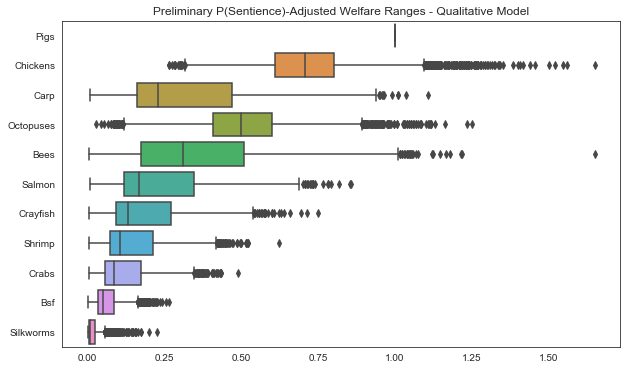

In [44]:
model = "Qualitative"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
qual_df, qual_adj_wrs = all_species_adj_wr(model)
print(qual_df)
box_plot_adj_wr(model, qual_adj_wrs)

### High-Confidence Simple Scoring

High-Confidence (Simple Scoring)
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.685    0.441     0.677     0.960
octopuses  0.504    0.256     0.495     0.777
bees       0.340    0.029     0.310     0.718
carp       0.303    0.052     0.230     0.674
salmon     0.223    0.037     0.168     0.494
crayfish   0.172    0.030     0.130     0.391
shrimp     0.136    0.023     0.104     0.311
crabs      0.111    0.018     0.084     0.256
bsf        0.060    0.012     0.048     0.138
silkworms  0.015    0.000     0.008     0.049


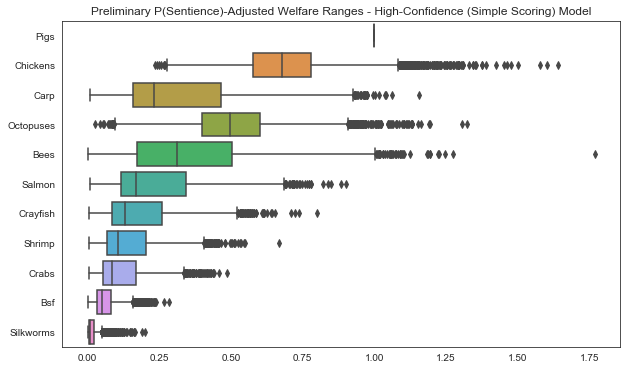

In [45]:
model = "High-Confidence (Simple Scoring)"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hc_ss_df, hc_ss_adj_wrs = all_species_adj_wr(model)
print(hc_ss_df)
box_plot_adj_wr(model, hc_ss_adj_wrs)


### Cubic

Cubic
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.505    0.235     0.467     0.907
octopuses  0.241    0.088     0.218     0.474
bees       0.127    0.009     0.106     0.320
carp       0.123    0.018     0.093     0.327
salmon     0.050    0.007     0.037     0.131
crayfish   0.028    0.004     0.021     0.079
shrimp     0.013    0.001     0.009     0.036
crabs      0.012    0.001     0.009     0.035
bsf        0.003    0.000     0.002     0.008
silkworms  0.001    0.000     0.000     0.003


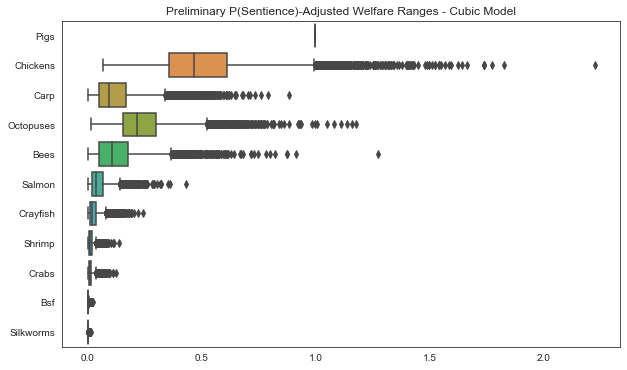

In [46]:
model = "Cubic"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
cubic_df, cubic_adj_wrs = all_species_adj_wr(model)
print(cubic_df)
box_plot_adj_wr(model, cubic_adj_wrs)


### High-Confidence Cubic

High-Confidence (Cubic)
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.459    0.185     0.413     0.907
octopuses  0.241    0.075     0.211     0.508
bees       0.127    0.008     0.100     0.333
carp       0.126    0.016     0.092     0.349
salmon     0.051    0.006     0.037     0.141
crayfish   0.027    0.003     0.019     0.079
shrimp     0.012    0.001     0.008     0.037
crabs      0.012    0.001     0.008     0.037
bsf        0.003    0.000     0.002     0.008
silkworms  0.001    0.000     0.000     0.002


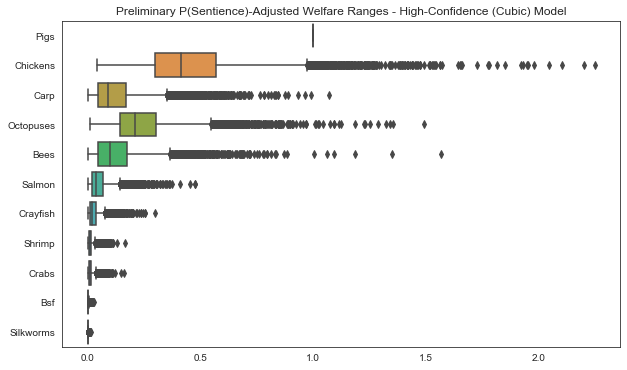

In [47]:
model = "High-Confidence (Cubic)"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hc_cubic_df, hc_cubic_adj_wrs = all_species_adj_wr(model)
print(hc_cubic_df)
box_plot_adj_wr(model, hc_cubic_adj_wrs)


### Qualitative Minus Social

Qualitative Minus Social
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.706    0.460     0.697     0.978
octopuses  0.542    0.279     0.535     0.827
bees       0.347    0.029     0.315     0.729
carp       0.294    0.051     0.222     0.647
salmon     0.223    0.037     0.167     0.491
crayfish   0.174    0.031     0.131     0.389
shrimp     0.150    0.026     0.115     0.337
crabs      0.122    0.020     0.092     0.277
bsf        0.065    0.014     0.052     0.146
silkworms  0.017    0.000     0.009     0.055


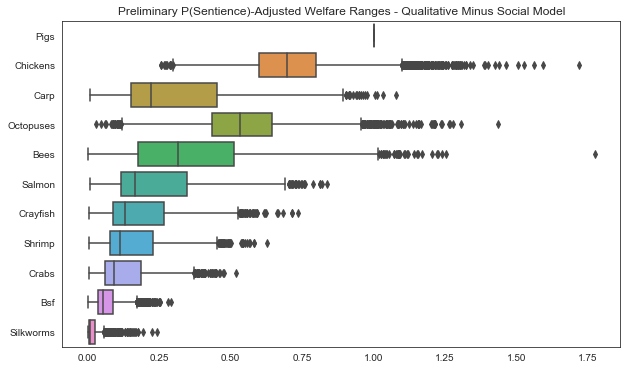

In [48]:
model = "Qualitative Minus Social"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
qms_df, qms_adj_wrs = all_species_adj_wr(model)
print(qms_df)
box_plot_adj_wr(model, qms_adj_wrs)


### Pleasure-and-pain-centric

Pleasure-and-pain-centric
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
octopuses  0.691    0.347     0.675     1.078
chickens   0.677    0.418     0.662     0.989
carp       0.404    0.069     0.307     0.913
bees       0.331    0.027     0.299     0.744
salmon     0.320    0.052     0.241     0.727
crayfish   0.241    0.041     0.184     0.557
shrimp     0.219    0.037     0.168     0.513
crabs      0.179    0.029     0.138     0.423
bsf        0.061    0.009     0.049     0.151
silkworms  0.020    0.000     0.011     0.069


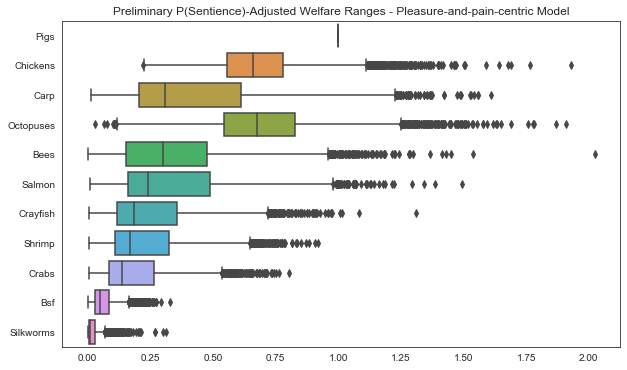

In [49]:
model = "Pleasure-and-pain-centric"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
ppc_df, ppc_adj_wrs = all_species_adj_wr(model)
print(ppc_df)
box_plot_adj_wr(model, ppc_adj_wrs)


### Higher-lower Pleasures

Higher-Lower Pleasures
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.580    0.301     0.548     0.971
octopuses  0.283    0.106     0.262     0.533
bees       0.175    0.013     0.151     0.422
carp       0.166    0.025     0.127     0.420
salmon     0.090    0.013     0.069     0.225
crayfish   0.041    0.005     0.031     0.109
crabs      0.030    0.004     0.023     0.082
shrimp     0.029    0.004     0.022     0.081
bsf        0.015    0.002     0.012     0.041
silkworms  0.003    0.000     0.002     0.013


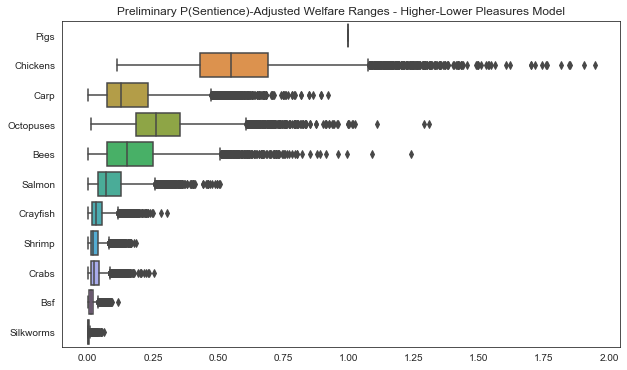

In [50]:
model = "Higher-Lower Pleasures"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hlp_df, hlp_adj_wrs = all_species_adj_wr(model)
print(hlp_df)
box_plot_adj_wr(model, hlp_adj_wrs)


### Undiluted Experience

Undiluted Experience
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
octopuses  1.499    0.646     1.386     2.717
pigs       1.000    1.000     1.000     1.000
shrimp     1.203    0.164     0.837     3.312
chickens   0.871    0.486     0.835     1.391
carp       0.696    0.110     0.532     1.678
crayfish   0.612    0.094     0.454     1.553
salmon     0.602    0.095     0.453     1.444
crabs      0.528    0.076     0.394     1.371
bees       0.392    0.032     0.347     0.916
bsf        0.294    0.038     0.216     0.769
silkworms  0.122    0.002     0.056     0.432


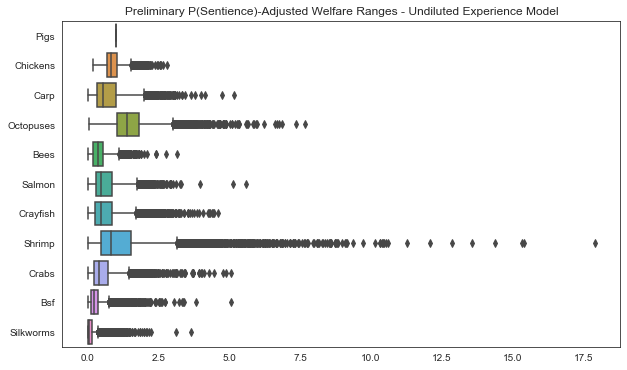

In [51]:
model = "Undiluted Experience"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
ue_df, ue_adj_wrs = all_species_adj_wr(model)
print(ue_df)
box_plot_adj_wr(model, ue_adj_wrs)


### Mixture

Mixture
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.677    0.328     0.673     1.042
octopuses  0.584    0.142     0.469     1.578
bees       0.279    0.019     0.239     0.697
carp       0.309    0.034     0.215     0.838
salmon     0.226    0.015     0.141     0.725
crayfish   0.190    0.008     0.100     0.647
shrimp     0.259    0.004     0.078     1.284
crabs      0.138    0.004     0.064     0.505
bsf        0.068    0.001     0.034     0.251
silkworms  0.025    0.000     0.005     0.088


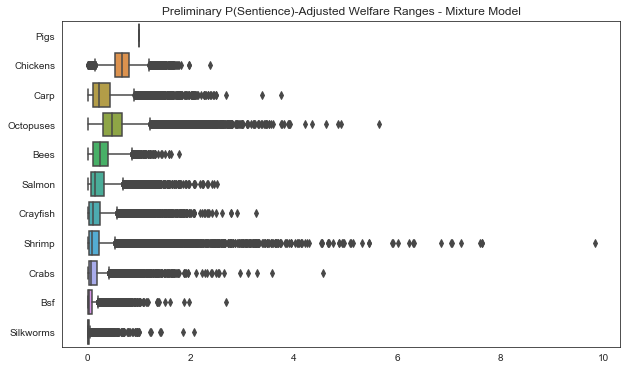

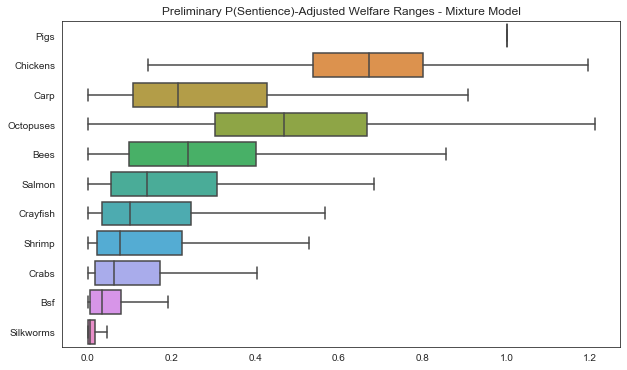

In [52]:
model = "Mixture"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
mix_df, mix_adj_wrs = all_species_adj_wr(model)
print(mix_df)
box_plot_adj_wr(model, mix_adj_wrs)

box_plot_adj_wr(model, mix_adj_wrs, showfliers=False)

def get_quartiles(mix_adj_wrs):
    percentiles = {}
    for i, species in enumerate(SPECIES2):
        percentiles[species] = {'25th': 0, '75th': 0}
        percentiles[species]['25th'] = np.percentile(mix_adj_wrs[i], 25)
        percentiles[species]['75th'] = np.percentile(mix_adj_wrs[i], 75)
    return percentiles


## Mixture With Neuron Count Model

Mixture Neuron Count
P(Sentience) Adjusted Welfare Range:
            Mean  5th-pct  50th-pct  95th-pct
pigs       1.000    1.000     1.000     1.000
chickens   0.650    0.321     0.639     1.037
octopuses  0.615    0.146     0.508     1.511
bees       0.248    0.001     0.203     0.678
carp       0.281    0.010     0.190     0.826
salmon     0.199    0.009     0.116     0.648
crayfish   0.168    0.000     0.081     0.613
shrimp     0.222    0.000     0.059     0.995
crabs      0.123    0.000     0.051     0.456
bsf        0.059    0.000     0.027     0.222
silkworms  0.022    0.000     0.003     0.082


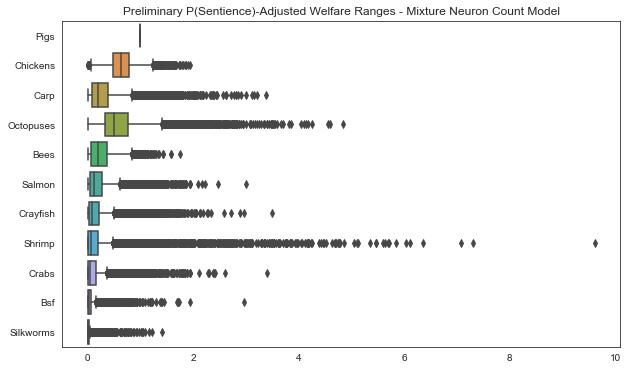

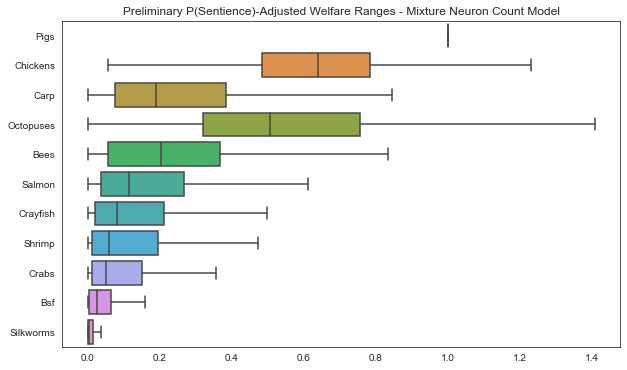

In [53]:
model = "Mixture Neuron Count"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
mix_df, mix_adj_wrs = all_species_adj_wr(model)
print(mix_df)
box_plot_adj_wr(model, mix_adj_wrs)

box_plot_adj_wr(model, mix_adj_wrs, showfliers=False)

def get_quartiles(mix_adj_wrs):
    percentiles = {}
    for i, species in enumerate(SPECIES2):
        percentiles[species] = {'25th': 0, '75th': 0}
        percentiles[species]['25th'] = np.percentile(mix_adj_wrs[i], 25)
        percentiles[species]['75th'] = np.percentile(mix_adj_wrs[i], 75)
    return percentiles



## Tests


In [54]:
import unittest
simple_models = {'Qualitative': {"Proxies": qual_proxies, "Function": qual_f}, 
                'High-Confidence (Simple Scoring)': {"Proxies": hc_proxies, "Function": qual_f}, 
                'Cubic': {"Proxies": cubic_proxies, "Function": cubic_f}, 
                'High-Confidence (Cubic)': {"Proxies": hc_proxies, "Function": cubic_f}, 
                'Qualitative Minus Social': {"Proxies": qms_proxies, "Function": qms_f}, 
                'Pleasure-and-pain-centric': {"Proxies": ppc_proxies, "Function": ppc_f}}

proxies = {'qualitative': {'List': qual_proxies_list, 'Set': qual_proxies}, 
            'cubic': {'List': cubic_proxies_list, 'Set': cubic_proxies}, 
            'qualitative minus social': {"List": qms_proxies_list, 'Set': qms_proxies},
            'pleasure-and-pain-centric': {"List": ppc_proxies_list, 'Set': ppc_proxies}, 
            'higher/lower pleasures - cognitive': {'List': hlp_cog_proxies_list, 'Set': hlp_cog_proxies},
            'higher-lower pleasures - hedonic': {'List': hlp_hed_proxies_list, 'Set': hlp_hed_proxies},
            'undiluted experience - cognitive': {'List': ue_cog_proxies_list, 'Set': ue_cog_proxies},
            'undiluted experience - hedonic': {'List': ue_hed_proxies_list, 'Set': ue_hed_proxies}}

complex_models = {'Higher-Lower Pleasures': {"Hedonic Proxies": hlp_hed_proxies, "Cognitive Proxies": hlp_cog_proxies, "Function": hlp_f}, 
                'Undiluted Experience': {"Hedonic Proxies": ue_hed_proxies, "Cognitive Proxies": ue_cog_proxies, "Function": ue_f}}

class TestSimpleFunctions(unittest.TestCase):

    def test_proxies(self):
        pass_test = True
        for model in proxies:
            if set(proxies[model]['List']) != proxies[model]['Set']:
                pass_test = False
        self.assertTrue(pass_test)

    def test_filter_proxies(self):
        pass_test = True
        for model in simple_models:
            model_proxies = simple_models[model]["Proxies"]
            for animal in data.keys():
                animal_scores = data[animal]["Scores"]
                if set(filter_proxies(animal_scores, model_proxies).keys()) != model_proxies:
                    pass_test = False
        self.assertTrue(pass_test)    

    def test_one_sim_wr(self):
        pass_test = True
        for x in [0, 1]:
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS
            for model in simple_models:
                model_proxies = simple_models[model]['Proxies']
                filtered_scores = filter_proxies(test_scores, model_proxies)

                human_sum = get_human_sum(model, model_proxies, hc_proxies)
                f = simple_models[model]['Function']
                prediction = f(x)
                for i in range(NUM_SCENARIOS):
                    p = one_sim_welfare_range(model, f, filtered_scores, i, 60, human_sum)
                    if p != prediction:
                        pass_test = False
                        print("Model: {}".format(model))
                        print("X: {}".format(x))
                        print("prediction: {}".format(prediction))
                        print("p: {}".format(p))
        self.assertTrue(pass_test)

def one_species_welfare_ranges_2(f, species_scores, cog_proxies, hed_proxies, hc_proxies, fff):
    cognitive_scores = filter_proxies(species_scores, cog_proxies)
    hedonic_scores = filter_proxies(species_scores, hed_proxies)
    human_sum_cog = get_human_sum_2(cog_proxies, hc_proxies)
    human_sum_hed = get_human_sum_2(hed_proxies, hc_proxies)
  
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range_2(f, cognitive_scores, hedonic_scores, human_sum_cog, human_sum_hed, i, fff)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list
    
class TestComplexFuctions(unittest.TestCase):
    def test_one_sim_relative_score(self):
        pass_test = True
        for x in [0,1]:
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS
            for model in complex_models:
                for term in {"Hedonic Proxies", "Cognitive Proxies"}:
                    model_proxies = complex_models[model][term]
                    filtered_proxies = filter_proxies(test_scores, model_proxies)
                    human_sum = get_human_sum_2(model_proxies, hc_proxies)
                    prediction = x
                    for i in range(NUM_SCENARIOS):
                        p = one_sim_relative_score(filtered_proxies, i, human_sum)
                        if p != prediction:
                            pass_test = False
                            print("Model: {}".format(model))
                            print("X: {}".format(x))
                            print("Term: {}".format(term))
                            print("Prediction: {}".format(prediction))
                            print("Actual: {}".format(p))
        self.assertTrue(pass_test)

    def test_one_sim_welare_range_2(self):
        pass_test = True
        for i, x in enumerate([(0.1, 1), (1, 0.1)]): 
            hed_test_scores = {}
            cog_test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    cog_test_scores[proxy] = [x[0]*HC_WEIGHT]*NUM_SCENARIOS
                    hed_test_scores[proxy] = [x[1]*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    cog_test_scores[proxy] = [x[0]]*NUM_SCENARIOS
                    hed_test_scores[proxy] = [x[1]]*NUM_SCENARIOS

            for model in complex_models:
                human_sum_cog = get_human_sum_2(complex_models[model]["Cognitive Proxies"], hc_proxies)
                human_sum_hed = get_human_sum_2(complex_models[model]["Hedonic Proxies"], hc_proxies)

                cog_model_proxies = complex_models[model]["Cognitive Proxies"]
                cog_proxies = filter_proxies(cog_test_scores, cog_model_proxies)
               
                hed_model_proxies = complex_models[model]["Hedonic Proxies"]
                hed_proxies = filter_proxies(hed_test_scores, hed_model_proxies)
                
                cog_rel_score = one_sim_relative_score(cog_proxies, 0, human_sum_cog)
                hed_rel_score = one_sim_relative_score(hed_proxies, 0, human_sum_hed)

                f = complex_models[model]["Function"]
                prediction = f(cog_rel_score, hed_rel_score)

                for i in range(NUM_SCENARIOS):
                    p = one_sim_welfare_range_2(f, cog_proxies, hed_proxies, human_sum_cog, human_sum_hed, i, 60)
                
                    if p != prediction:
                        pass_test = False
                        print("Model: {}".format(model))
                        print("X: {}".format(x))
                        print("Prediction: {}".format(prediction))
                        print("Actual: {}".format(p))
        self.assertTrue(pass_test)

    def test_one_species_wr_2(self):
        pass_test = True
        for x in {1}: 
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS

        for model in complex_models:
            f = complex_models[model]["Function"]
            cog_proxies = complex_models[model]["Cognitive Proxies"]
            hed_proxies = complex_models[model]["Hedonic Proxies"]
            wr_list = one_species_welfare_ranges_2(f, test_scores, cog_proxies, hed_proxies, hc_proxies, 60)
            expect = [1]*NUM_SCENARIOS
            if wr_list != expect:
                pass_test = False
                print("Model: ", model)
                print("Expected: ", expect[0:10])
                print("Actual: ", wr_list[0:10])
        self.assertTrue(pass_test)

class TestMultiplication(unittest.TestCase):
    models = ['Qualitative', 'High-Confidence (Simple Scoring)', \
                'Cubic', 'High-Confidence (Cubic)', \
                'Qualitative Minus Social', 'Pleasure-and-pain-centric', \
                'Higher-Lower Pleasures', 'Undiluted Experience', "Mixture"]
    def test_check_multiplication(self):
        pass_test = True
        
        for model in models: 
            
            for species in SPECIES2:
                if species != 'shrimp':
                    with open(os.path.join('sentience_estimates', '{}_psent_hv1_model.p'.format(species)), 'rb') as f_s:
                        species_psent = list(pickle.load(f_s))
                else:
                    with open(os.path.join('sentience_estimates', 'shrimp_assumed_psent.p'), 'rb') as f_s:
                        species_psent = list(pickle.load(f_s))
                with open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model)), 'rb') as f_wr:
                    species_wr = list(pickle.load(f_wr)) 
                exp_adj_wrs = []
                for i in range(NUM_SCENARIOS):
                    adj_wr = max(species_psent[i]*species_wr[i],0)
                    exp_adj_wrs.append(adj_wr)
                adj_wr = one_species_adj_wr(species, model)
                if exp_adj_wrs != adj_wr:
                    pass_test = False
        self.assertTrue(pass_test)


res2 = unittest.main(argv=[''], verbosity=3, exit=False)

test_one_sim_relative_score (__main__.TestComplexFuctions) ... ERROR
test_one_sim_welare_range_2 (__main__.TestComplexFuctions) ... ERROR
test_one_species_wr_2 (__main__.TestComplexFuctions) ... ERROR
test_check_multiplication (__main__.TestMultiplication) ... ERROR
test_filter_proxies (__main__.TestSimpleFunctions) ... ok
test_one_sim_wr (__main__.TestSimpleFunctions) ... ERROR
test_proxies (__main__.TestSimpleFunctions) ... ok

ERROR: test_one_sim_relative_score (__main__.TestComplexFuctions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Laura\AppData\Local\Temp\ipykernel_5852\2877087625.py", line 93, in test_one_sim_relative_score
    human_sum = get_human_sum_2(model_proxies, hc_proxies)
NameError: name 'get_human_sum_2' is not defined

ERROR: test_one_sim_welare_range_2 (__main__.TestComplexFuctions)
----------------------------------------------------------------------
Traceback (most recent call last):
